# Ideas
1. Compare sentiment between Instacart, DoorDash, GrubHub, Uber Eats and Postmates tweets
2. Compare how quantity of tweets containing Instacart in a day correlate with number COVID-19 cases of that day
3. Restrict tweets to locations on official lockdown and view density of tweets before and after lockdown
  - "instacart" near:"New York, USA" within:15mi

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re

from nltk.sentiment.vader import SentimentIntensityAnalyzer

warnings.filterwarnings('ignore')

# PART 1: COMPARING COMPANIES
<a href="https://www.selenium.dev/">Selenium</a> is a package used to automate web browsing. To run this yourself you'll have to download the Selenium WebDriver and set the ```path``` variable to where it is located on your computer. I have found that Google Chrome is much faster than FireFox and therefore recommend Chrome.

The problem using Selenium to scrape tweets is Twitter makes their HTML tags incredibly obfuscated. The following is an example of the class names used to store a single tweet:
<img src="https://i.ibb.co/kMWwPWr/twitter-tags-hard.jpg" alt="twitter-tags-hard" border="0">

To get around this, I download a Chrome extension that displays the old twitter layout. With this I'm able to get the tweets by simply looking at class name ```"content"```:
<img src="https://i.ibb.co/R2wb5ZV/twitter-easy-tags.jpg" alt="twitter-easy-tags" border="0">

So I open Chrome with Selenium, download the Chrome extension, search for the desired results, then I scroll for a long time to the bottom of the search results in order to load and save all the tweets!

In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
import time

# Setting path and opening browser
path = r'C:\\Users\\lukef\\AppData\\Local\\BrowserDriver\\chromedriver.exe'
driver = webdriver.Chrome(executable_path = path)#, options=opts)

# Navigating to old twitter layout extension
site = 'https://chrome.google.com/webstore/detail/old-twitter-layout/jjldkokjmjdnlnifmehbljdafklejeha/related?hl=en'
driver.get(site)
time.sleep(2)

# Building actions class to interact with the website
actions = ActionChains(driver)

# Click download button
actions.move_to_element(driver.find_element_by_class_name('g-c-Hf'))
actions.click().perform()

# Now you must click on download!!!
time.sleep(5)

In [2]:
companies = ['Instacart', 'DoorDash', 'GrubHub', 'Uber Eats', 'Postmates']
sites = ['https://twitter.com/search?f=tweets&vertical=default&q='+company+'&l=en&src=typd' for company in companies]


In [3]:
tweets = []
for i, company in enumerate(companies):
    # Navigating to twitter search
    driver.get(sites[i])
    time.sleep(2)

    # Scroll down to load more tweets
    body = driver.find_element_by_css_selector('body')
    start = time.time()
    while time.time() - start < 60*10:
        body.send_keys(Keys.PAGE_DOWN)

    # Get tweets
    twitter_elms = driver.find_elements_by_class_name("content")
    tweets.append([twitter_elms[i].text for i in range(len(twitter_elms))])
    
# Closing browser
driver.close()

In [10]:
df_values = [[tweets[j][i],companies[j]] for j in range(len(companies)) \
                                         for i in range(len(tweets[j]))]

df = pd.DataFrame(df_values, columns=['raw_text','company'])

df.to_csv('raw_tweets_df.csv', index= False)

df.head()

,raw_text,company
0,Diversity News Magazine\n @RealDNewsMag\n12m\n...,Instacart
1,Deb WARRIOR WOMAN Farmer\n @realdebfarmer\n13m...,Instacart
2,Polly Em\n @PollyMoxie1\n13m\n13 minutes ago\n...,Instacart
3,shevonn damn\n @thatsasexyname\n14m\n14 minute...,Instacart
4,Hillary Bilheimer\n @hbilheimer\n20m\n20 minut...,Instacart


## Reading in dataframe

In [73]:
df = pd.read_csv('raw_tweets_df.csv')
df.head()

,raw_text,company
0,Diversity News Magazine\n @RealDNewsMag\n12m\n...,Instacart
1,Deb WARRIOR WOMAN Farmer\n @realdebfarmer\n13m...,Instacart
2,Polly Em\n @PollyMoxie1\n13m\n13 minutes ago\n...,Instacart
3,shevonn damn\n @thatsasexyname\n14m\n14 minute...,Instacart
4,Hillary Bilheimer\n @hbilheimer\n20m\n20 minut...,Instacart


## Removing duplicates
Since I'd like to compare the sentiment of tweets of each company I remove any duplicate tweets meaning more than one company was referenced in the same tweet.

In [74]:
df = df[~df['raw_text'].duplicated(keep=False)]
df.head()

,raw_text,company
0,Diversity News Magazine\n @RealDNewsMag\n12m\n...,Instacart
1,Deb WARRIOR WOMAN Farmer\n @realdebfarmer\n13m...,Instacart
2,Polly Em\n @PollyMoxie1\n13m\n13 minutes ago\n...,Instacart
3,shevonn damn\n @thatsasexyname\n14m\n14 minute...,Instacart
4,Hillary Bilheimer\n @hbilheimer\n20m\n20 minut...,Instacart


## Extracting Time/Date
We can see that the time and date is always sandwiched as so:  
&ensp;&ensp;```\n @username\n(TIME/DATE)\n```    
So I'll use a regular expression to capture just that.

In [75]:
regex = r'\n @.*?\n(.*?)\n'
df['date'] = df['raw_text'].str.extract(regex)
df.head()

,raw_text,company,date
0,Diversity News Magazine\n @RealDNewsMag\n12m\n...,Instacart,12m
1,Deb WARRIOR WOMAN Farmer\n @realdebfarmer\n13m...,Instacart,13m
2,Polly Em\n @PollyMoxie1\n13m\n13 minutes ago\n...,Instacart,13m
3,shevonn damn\n @thatsasexyname\n14m\n14 minute...,Instacart,14m
4,Hillary Bilheimer\n @hbilheimer\n20m\n20 minut...,Instacart,20m


## Filling in missing time/date values
Looks like some of them don't have the ```'\n'``` before the username, the following regular expression fixes that for the missing values.

In [76]:
missing_indices = df[df['date'].isna()].index
df.loc[missing_indices,'raw_text']

1545      @Rapidity856\n10h\n10 hours ago\nMore\nReplyi...
2824      @HARRlESTILES\n4h\n4 hours ago\nMore\ndoor da...
3433      @sochaoticdude\n7h\n7 hours ago\nMore\nif any...
4578      @juliololololol\n12h\n12 hours ago\nMore\nRep...
8240      @HighkeyMami\n10m\n10 minutes ago\nMore\norde...
10447     @Rapidity856\n10h\n10 hours ago\nMore\nReplyi...
10861     @Loucifer_III\n11h\n11 hours ago\nMore\nUber ...
11751     @gngdemie\n5h\n5 hours ago\nMore\nReplying to...
12964     @stopchrissy\nMar 23\nMore\nramsis (it depend...
12977     @JULlANNA21\nMar 23\nMore\nTIP UR MF POSTMATE...
13121     @joochanshp\nMar 23\nMore\noomfmates is postm...
Name: raw_text, dtype: object

In [77]:
regex = '@.*?\n(.*?)\n'
df.loc[missing_indices,'date'] = df.loc[missing_indices,'raw_text'].str.extract(regex)[0]

## Extracting and cleaning raw tweet text
The actual text comes in-between ```\nMore\n``` and ```\nReply``` so we'll try extracting between there.

In [78]:
df['text'] = df['raw_text'].str.extract(r'\nMore\n([\s\S]*)\nReply')
df.head()

,raw_text,company,date,text
0,Diversity News Magazine\n @RealDNewsMag\n12m\n...,Instacart,12m,"Workers on Postmates, Instacart, DoorDash & ot..."
1,Deb WARRIOR WOMAN Farmer\n @realdebfarmer\n13m...,Instacart,13m,Replying to @BaldBoss68 @LifeOnLiberty @Instac...
2,Polly Em\n @PollyMoxie1\n13m\n13 minutes ago\n...,Instacart,13m,@Instacart where is my order? It has been 7 ho...
3,shevonn damn\n @thatsasexyname\n14m\n14 minute...,Instacart,14m,"First few symptoms, here it comes.\nI'm fucked..."
4,Hillary Bilheimer\n @hbilheimer\n20m\n20 minut...,Instacart,20m,Has anyone else had a recent @Instacart custom...


The regular expression almost perfect but missed one tweet, since it is only one I'm simply going to fill it in manually.

In [79]:
df.loc[4188, 'text'] = 'Spent $30 on DoorDash and fell asleep'

This looks good but the retweets still have a lot of junk in them. For the time being I'm just going to choose to extract what the retweeter added and ignore the base tweet as they may have different sentiments. Some other methodology could be used in the future.

In [80]:
regex = 'Retweeted[\s\S]*?\n([\s\S]*)\n[\s\S]*added,'

indices_matches = df[df['text'].str.contains(regex)].index
df.loc[indices_matches, 'text'] = df.loc[indices_matches, 'text'].str.extract(regex)[0]

Finally we'll clean out the ```Replying to @user1 @user2\n``` part of the reply tweets.

In [94]:
regex = r'Replying to.*?\n([\s\S]*)'

replies_indices = df[df['text'].str.contains(r'Replying to')].index
df.loc[replies_indices, 'text'] = df.loc[replies_indices,'text'].str.extract(regex)[0]

df.head()

,raw_text,company,date,text
0,Diversity News Magazine\n @RealDNewsMag\n12m\n...,Instacart,12m,"Workers on Postmates, Instacart, DoorDash & ot..."
1,Deb WARRIOR WOMAN Farmer\n @realdebfarmer\n13m...,Instacart,13m,"Being a veteran online shopper, I tried @Insta..."
2,Polly Em\n @PollyMoxie1\n13m\n13 minutes ago\n...,Instacart,13m,@Instacart where is my order? It has been 7 ho...
3,shevonn damn\n @thatsasexyname\n14m\n14 minute...,Instacart,14m,"First few symptoms, here it comes.\nI'm fucked..."
4,Hillary Bilheimer\n @hbilheimer\n20m\n20 minut...,Instacart,20m,Has anyone else had a recent @Instacart custom...


## Saving the cleaned dataframe

In [96]:
df.to_csv('cleaned_tweets.csv', index = False)

In [3]:
df = pd.read_csv('cleaned_tweets.csv')

## Getting sentiment of each tweet
I'll be using the vader sentiment analyzer. Before you can initialize the analyzer you must download the lexicon file, you can do so by running:
```Python 
import nltk
nltk.download('vader_lexicon')```

In [4]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(row):
    return analyzer.polarity_scores(row['text'])['compound']

df['sentiment'] = df.apply(get_sentiment, axis = 1)
df.head()

,raw_text,company,date,text,sentiment
0,Diversity News Magazine\n @RealDNewsMag\n12m\n...,Instacart,12m,"Workers on Postmates, Instacart, DoorDash & ot...",0.3616
1,Deb WARRIOR WOMAN Farmer\n @realdebfarmer\n13m...,Instacart,13m,"Being a veteran online shopper, I tried @Insta...",-0.3595
2,Polly Em\n @PollyMoxie1\n13m\n13 minutes ago\n...,Instacart,13m,@Instacart where is my order? It has been 7 ho...,0.0000
3,shevonn damn\n @thatsasexyname\n14m\n14 minute...,Instacart,14m,"First few symptoms, here it comes.\nI'm fucked...",-0.8225
4,Hillary Bilheimer\n @hbilheimer\n20m\n20 minut...,Instacart,20m,Has anyone else had a recent @Instacart custom...,0.3612


## Plotting average sentiments

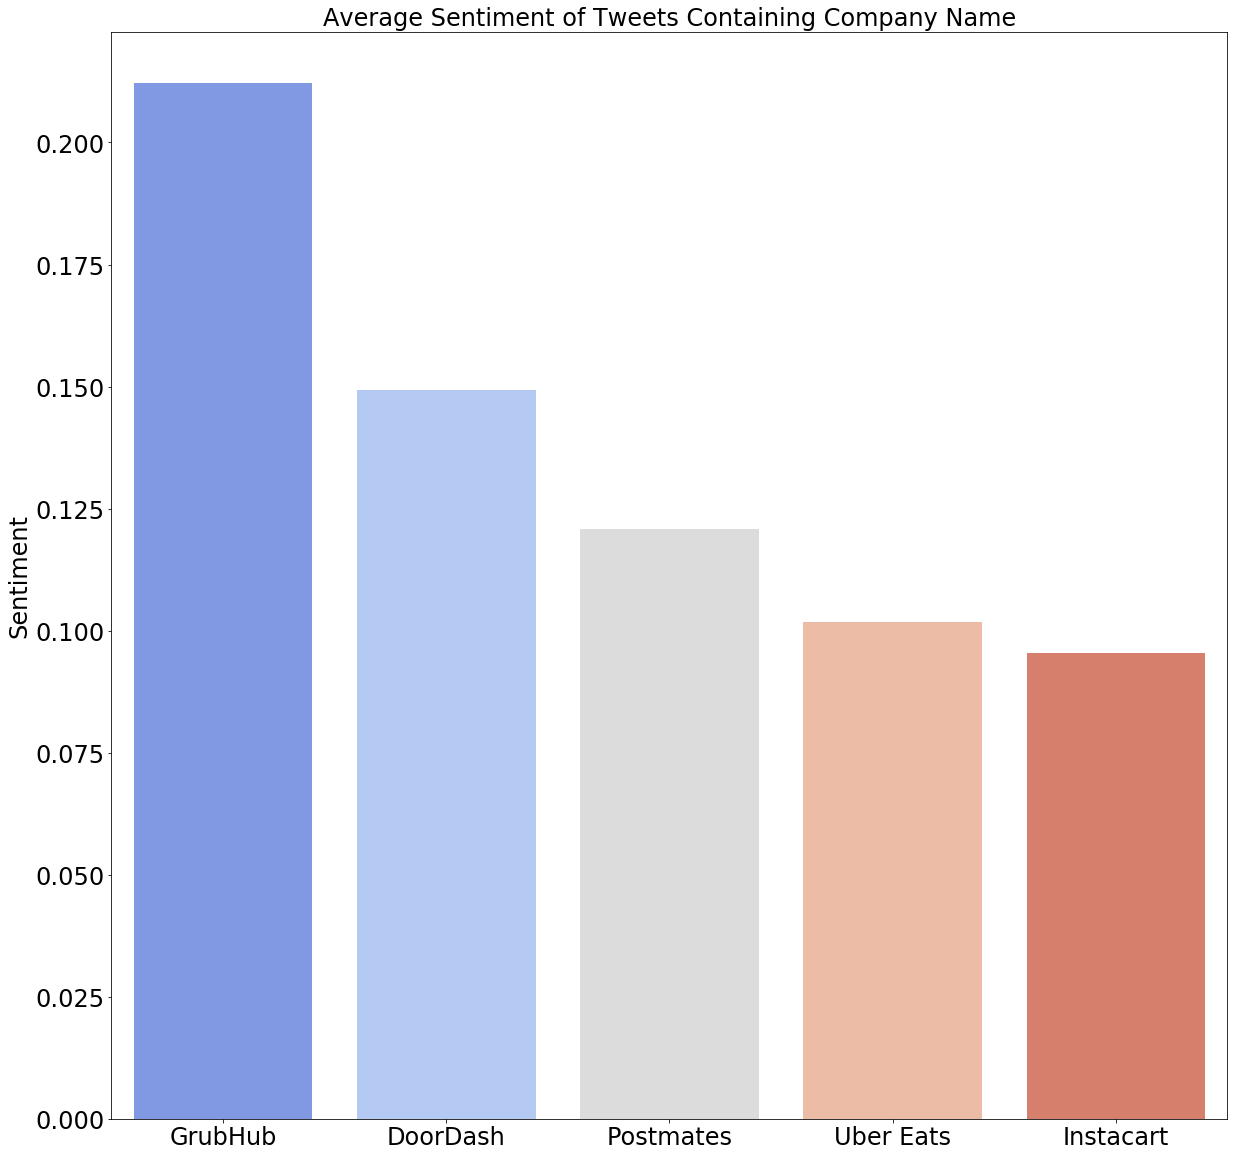

In [23]:
# Setting up the figure and axes
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)

# Grouping to get means of each company and creating the barplot
means = df.groupby('company').mean().reset_index()
sns.barplot(x='company', y='sentiment',
            data=means.sort_values(by='sentiment',ascending=False),
            palette="coolwarm");

# Labeling (and un-labelling x-axis)
ax.set_title('Average Sentiment of Tweets Containing Company Name')
ax.set_ylabel('Sentiment')
ax.set_xlabel('')

# Increasing size of text and ticks
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24);

We see that GrubHub has the highest average sentiment with a score above 0.2, while instacart has the lowest with an average sentiment score just below 0.1. While this may seem large, and indeed it is twice as big, it is worth noting that the standard deviation of the scores of all the tweets is 0.45, and thus Grubhub has a score only a quarter of a standard deviation above instacart.

## Boxplots
To get some more detail about the actual distribution of sentiments for each company beyond just the mean we'll create side by side boxplots below, where the white circles indicate the mean sentiment score of the company (same as above), and the red line indicates the median score.

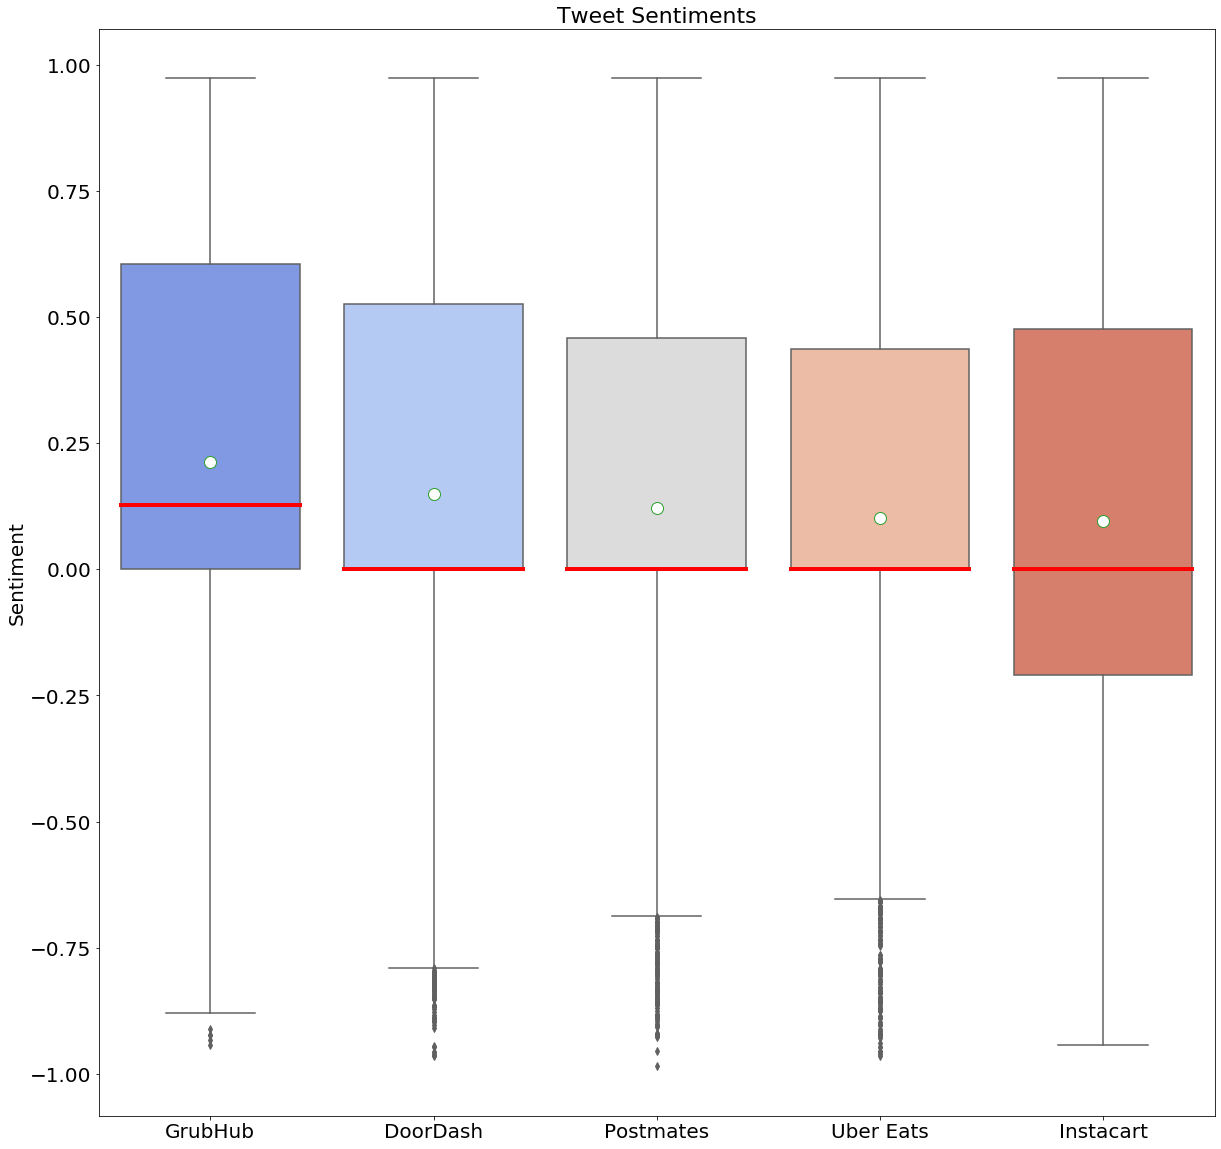

In [30]:
# Setting up the figure and axes
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)

# Creating the boxplot
sns.boxplot(x='company', y='sentiment', data=df, ax=ax,
            order = ['GrubHub','DoorDash','Postmates','Uber Eats', 'Instacart'],
            palette="coolwarm",
            medianprops={'color':'red', 'linewidth':4},
            showmeans = True,
            meanprops={'marker':'o','markerfacecolor':'white','markersize':12})

# Labeling
ax.set_title('Tweet Sentiments', fontdict={'fontsize':22})
ax.set_ylabel('Sentiment')
ax.set_xlabel('')

# Increasing size of text and ticks
for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20);
    
# Saving the graph
fig.savefig('Tweets Sentiments.png', dpi = fig.dpi, bbox_inches = "tight");

Above we can see more clearly that the means are indeed not very far apart. We can also see that the VADER sentiment score is often exactly 0 as that's the median value of every company except GrubHub and it's also the 25th percentile for every company except instacart.